# Análisis Topológico de Datos para Descubrimiento de Contenido en Textos

Este cuaderno implementa un pipeline completo de Análisis Topológico de Datos (ATD) para caracterizar textos en español según su contenido narrativo, descriptivo y otros tipos textuales.

## Pipeline:
1. Selección y preparación del texto
2. Limpieza y preprocesamiento
3. Construcción de grafo de co-ocurrencia con PMI (Pointwise Mutual Information)
4. Construcción del complejo simplicial
5. Filtración
6. Diagramas de persistencia y códigos de barras
7. Análisis e interpretación

## 1. Instalación de Dependencias y Importaciones

In [1]:
# Instalación de paquetes necesarios
!pip install numpy pandas matplotlib networkx nltk scikit-learn scipy
!pip install ripser persim gudhi
!pip install spacy
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 7.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.6 MB/s eta 0:00:0000:01
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=88b0f0f27308355093a9636163a4764f32a59f0d2881c1288ee5514bf94537b3
  Stored in directory: /Users/cero/Library/Caches/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 81.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 9.1 M

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import spacy
from collections import Counter, defaultdict
from itertools import combinations
import re
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Para ATD
import gudhi
from ripser import ripser
import persim

# Descargar recursos de NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Cargar modelo de español
nlp = spacy.load('es_core_news_sm')

plt.style.use('seaborn-v0_8-darkgrid')
print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


## 2. Texto de Ejemplo

Utilizaremos un texto que combina diferentes tipos de contenido:
- **Narrativo**: Cuenta una historia con acciones y eventos temporales
- **Descriptivo**: Describe lugares, objetos o personas
- **Expositivo**: Explica conceptos o información
- **Argumentativo**: Presenta opiniones o razonamientos

In [4]:
texto_ejemplo = """
El viaje comenzó al amanecer. María caminaba por el sendero mientras observaba el paisaje. 
El bosque era denso y oscuro, con árboles altos que bloqueaban la luz del sol. Las hojas 
formaban un dosel verde que se extendía hasta donde alcanzaba la vista.

La fotosíntesis es el proceso mediante el cual las plantas convierten la luz solar en energía. 
Este mecanismo biológico es fundamental para la vida en la Tierra. Las plantas absorben dióxido 
de carbono y liberan oxígeno, manteniendo el equilibrio atmosférico.

De repente, María escuchó un ruido. Se detuvo y miró a su alrededor. Un ciervo apareció 
entre los árboles y la observó con curiosidad. Ella sonrió y continuó su camino.

Es evidente que los bosques desempeñan un papel crucial en nuestro ecosistema. Debemos 
protegerlos porque proporcionan hábitat para la fauna, purifican el aire y regulan el clima. 
La conservación forestal no es opcional, es una necesidad imperativa para las generaciones 
futuras.

Al llegar al claro, María encontró un pequeño lago. El agua era cristalina y reflejaba 
el cielo azul. Se sentó en una roca y sacó su cuaderno para escribir sobre su experiencia.
"""

print("Texto cargado:")
print(f"Longitud: {len(texto_ejemplo)} caracteres")
print(f"Número de líneas: {len(texto_ejemplo.split('.'))}")
print("\nPrimeras líneas:")
print(texto_ejemplo[:200] + "...")

Texto cargado:
Longitud: 1153 caracteres
Número de líneas: 18

Primeras líneas:

El viaje comenzó al amanecer. María caminaba por el sendero mientras observaba el paisaje. 
El bosque era denso y oscuro, con árboles altos que bloqueaban la luz del sol. Las hojas 
formaban un dosel...


## 3. Limpieza y Preprocesamiento del Texto

Pasos:
- Tokenización
- Eliminación de stopwords
- Lematización
- Filtrado de puntuación y caracteres especiales

In [5]:
def limpiar_texto(texto):
    """Limpia y preprocesa el texto"""
    # Procesar con spaCy
    doc = nlp(texto.lower())
    
    # Filtrar tokens: eliminar stopwords, puntuación, espacios
    tokens_limpios = [
        token.lemma_ for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and not token.is_space
        and len(token.text) > 2
        and token.is_alpha
    ]
    
    return tokens_limpios, doc

# Aplicar limpieza
tokens, doc_procesado = limpiar_texto(texto_ejemplo)

print("Estadísticas del texto procesado:")
print(f"Tokens originales: {len([t for t in doc_procesado])}")
print(f"Tokens después de limpieza: {len(tokens)}")
print(f"Vocabulario único: {len(set(tokens))}")
print(f"\nPrimeros 30 tokens limpios:")
print(tokens[:30])

Estadísticas del texto procesado:
Tokens originales: 224
Tokens después de limpieza: 95
Vocabulario único: 88

Primeros 30 tokens limpios:
['viaje', 'comenzar', 'amanecer', 'maría', 'caminar', 'sendero', 'observar', 'paisaje', 'bosque', 'denso', 'oscuro', 'árbol', 'alto', 'bloquear', 'luz', 'sol', 'hoja', 'formar', 'dosel', 'verde', 'extender', 'alcanzar', 'vista', 'fotosíntesis', 'proceso', 'planta', 'convertir', 'luz', 'solar', 'energía']


In [ ]:
# Análisis de frecuencias
frecuencias = Counter(tokens)
palabras_comunes = frecuencias.most_common(15)

print("Palabras más frecuentes:")
for palabra, freq in palabras_comunes:
    print(f"  {palabra}: {freq}")

# Visualización
fig, ax = plt.subplots(figsize=(12, 5))
palabras, freqs = zip(*palabras_comunes)
ax.bar(palabras, freqs, color='steelblue', alpha=0.7)
ax.set_xlabel('Palabras', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Palabras más frecuentes en el texto', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 4. Construcción de Grafo de Co-ocurrencia con PMI

### Pointwise Mutual Information (PMI)

PMI mide la asociación entre dos palabras:

$$PMI(w_i, w_j) = \log \frac{P(w_i, w_j)}{P(w_i) \cdot P(w_j)}$$

Donde:
- $P(w_i, w_j)$ es la probabilidad de co-ocurrencia
- $P(w_i)$ y $P(w_j)$ son las probabilidades individuales

Utilizamos una ventana deslizante para capturar contextos locales.

In [6]:
def calcular_coocurrencias(tokens, ventana=5):
    """Calcula matriz de co-ocurrencias con ventana deslizante"""
    vocab = list(set(tokens))
    vocab_idx = {palabra: idx for idx, palabra in enumerate(vocab)}
    n_vocab = len(vocab)
    
    # Matriz de co-ocurrencias
    coocurrencias = np.zeros((n_vocab, n_vocab))
    
    # Ventana deslizante
    for i, palabra in enumerate(tokens):
        idx_palabra = vocab_idx[palabra]
        
        # Contexto: ventana antes y después
        inicio = max(0, i - ventana)
        fin = min(len(tokens), i + ventana + 1)
        
        for j in range(inicio, fin):
            if i != j:
                idx_contexto = vocab_idx[tokens[j]]
                coocurrencias[idx_palabra, idx_contexto] += 1
    
    return coocurrencias, vocab, vocab_idx

coocurrencias, vocab, vocab_idx = calcular_coocurrencias(tokens, ventana=5)

print(f"Matriz de co-ocurrencias: {coocurrencias.shape}")
print(f"Total de co-ocurrencias: {int(coocurrencias.sum())}")
print(f"Co-ocurrencias no cero: {np.count_nonzero(coocurrencias)}")

Matriz de co-ocurrencias: (88, 88)
Total de co-ocurrencias: 920
Co-ocurrencias no cero: 916


In [7]:
def calcular_pmi(coocurrencias, vocab):
    """Calcula Pointwise Mutual Information"""
    n_vocab = len(vocab)
    total = coocurrencias.sum()
    
    # Probabilidades individuales
    prob_palabras = coocurrencias.sum(axis=1) / total
    
    # Matriz PMI
    pmi = np.zeros((n_vocab, n_vocab))
    
    for i in range(n_vocab):
        for j in range(n_vocab):
            if coocurrencias[i, j] > 0:
                prob_conjunta = coocurrencias[i, j] / total
                prob_independiente = prob_palabras[i] * prob_palabras[j]
                
                if prob_independiente > 0:
                    pmi[i, j] = np.log(prob_conjunta / prob_independiente)
    
    # PMI positivo (PPMI) - valores negativos a 0
    ppmi = np.maximum(pmi, 0)
    
    return pmi, ppmi

pmi, ppmi = calcular_pmi(coocurrencias, vocab)

print("Estadísticas de PMI:")
print(f"  PMI mínimo: {pmi[pmi != 0].min():.3f}")
print(f"  PMI máximo: {pmi.max():.3f}")
print(f"  PMI promedio: {pmi[pmi != 0].mean():.3f}")
print(f"\nEstadísticas de PPMI:")
print(f"  PPMI máximo: {ppmi.max():.3f}")
print(f"  PPMI promedio: {ppmi[ppmi != 0].mean():.3f}")
print(f"  Conexiones positivas: {np.count_nonzero(ppmi)}")

Estadísticas de PMI:
  PMI mínimo: 0.496
  PMI máximo: 3.423
  PMI promedio: 2.060

Estadísticas de PPMI:
  PPMI máximo: 3.423
  PPMI promedio: 2.060
  Conexiones positivas: 916


Grafo de co-ocurrencia:
  Nodos: 88
  Aristas: 458
  Densidad: 0.1196
  Componentes conexas: 1


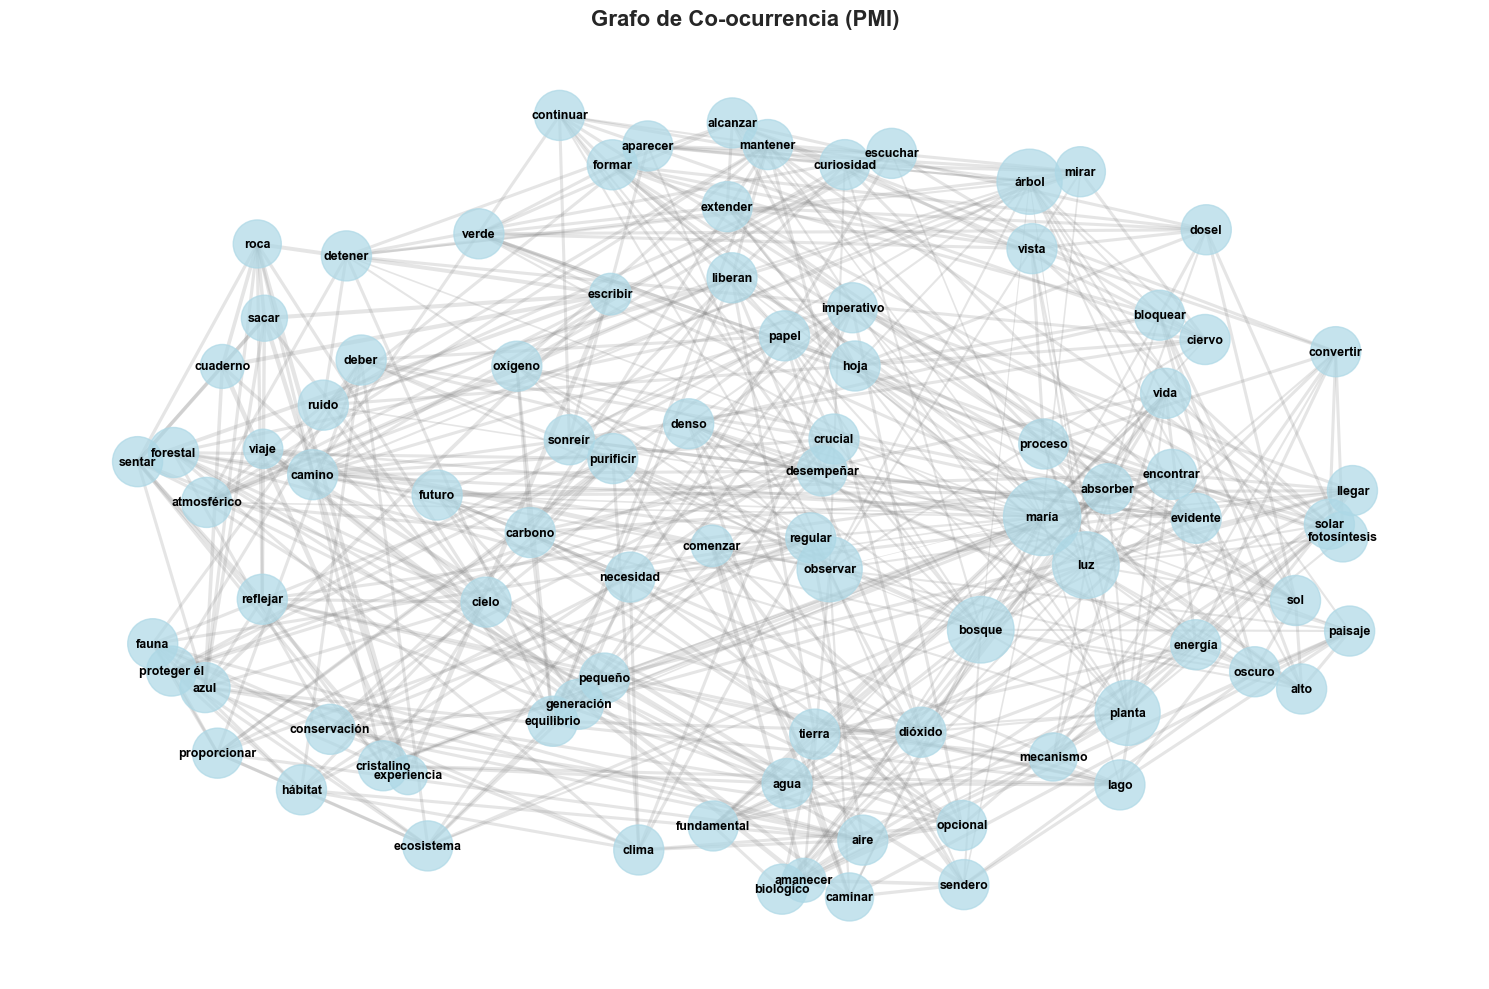

In [8]:
# Crear grafo de co-ocurrencia
def crear_grafo_coocurrencia(ppmi, vocab, umbral=0.5):
    """Crea grafo de co-ocurrencia usando PPMI"""
    G = nx.Graph()
    
    # Agregar nodos
    for palabra in vocab:
        G.add_node(palabra)
    
    # Agregar aristas con peso PPMI
    n_vocab = len(vocab)
    for i in range(n_vocab):
        for j in range(i+1, n_vocab):
            if ppmi[i, j] > umbral:
                G.add_edge(vocab[i], vocab[j], weight=ppmi[i, j])
    
    return G

G = crear_grafo_coocurrencia(ppmi, vocab, umbral=0.3)

print("Grafo de co-ocurrencia:")
print(f"  Nodos: {G.number_of_nodes()}")
print(f"  Aristas: {G.number_of_edges()}")
print(f"  Densidad: {nx.density(G):.4f}")
print(f"  Componentes conexas: {nx.number_connected_components(G)}")

# Visualizar grafo
fig, ax = plt.subplots(figsize=(15, 10))

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Grado de nodos para tamaño
node_sizes = [300 + 100 * G.degree(node) for node in G.nodes()]

# Pesos de aristas
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

# Dibujar
nx.draw_networkx_edges(G, pos, alpha=0.2, width=weights, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                       alpha=0.7, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title('Grafo de Co-ocurrencia (PMI)', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Construcción del Complejo Simplicial

Construimos un **complejo de Vietoris-Rips** a partir del grafo de co-ocurrencia.

Un complejo simplicial captura relaciones de orden superior:
- 0-simplices: Palabras individuales (nodos)
- 1-simplices: Pares de palabras (aristas)
- 2-simplices: Triángulos de palabras
- k-simplices: Grupos de k+1 palabras relacionadas

In [9]:
# Convertir grafo a matriz de distancias
def grafo_a_matriz_distancia(G, vocab):
    """Convierte grafo con pesos PPMI a matriz de distancias"""
    n = len(vocab)
    distancias = np.full((n, n), np.inf)
    
    # Diagonal = 0
    np.fill_diagonal(distancias, 0)
    
    # Convertir PPMI a distancia: dist = 1 / (1 + PPMI)
    vocab_idx = {palabra: idx for idx, palabra in enumerate(vocab)}
    
    for u, v, data in G.edges(data=True):
        i, j = vocab_idx[u], vocab_idx[v]
        peso = data['weight']
        dist = 1.0 / (1.0 + peso)  # Inversamente proporcional a PMI
        distancias[i, j] = dist
        distancias[j, i] = dist
    
    return distancias

matriz_distancias = grafo_a_matriz_distancia(G, vocab)

print("Matriz de distancias:")
print(f"  Forma: {matriz_distancias.shape}")
print(f"  Distancia mínima (no-diagonal): {matriz_distancias[matriz_distancias > 0].min():.4f}")
print(f"  Distancia máxima finita: {matriz_distancias[matriz_distancias < np.inf].max():.4f}")
print(f"  Conexiones finitas: {np.sum(np.isfinite(matriz_distancias)) - len(vocab)}")

Matriz de distancias:
  Forma: (88, 88)
  Distancia mínima (no-diagonal): 0.2261
  Distancia máxima finita: 0.6683
  Conexiones finitas: 916


In [10]:
# Construir complejo de Rips con GUDHI
def construir_complejo_rips(matriz_distancias, max_dimension=2, max_edge_length=2.0):
    """Construye complejo de Vietoris-Rips usando GUDHI"""
    # Reemplazar infinitos con valor grande
    matriz_finita = matriz_distancias.copy()
    matriz_finita[np.isinf(matriz_finita)] = max_edge_length * 2
    
    # Crear complejo de Rips
    rips_complex = gudhi.RipsComplex(distance_matrix=matriz_finita, 
                                      max_edge_length=max_edge_length)
    
    # Crear árbol simplex
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    
    return simplex_tree

simplex_tree = construir_complejo_rips(matriz_distancias, max_dimension=2, max_edge_length=1.5)

print("Complejo Simplicial (Vietoris-Rips):")
print(f"  Número de simplices: {simplex_tree.num_simplices()}")
print(f"  Número de vértices: {simplex_tree.num_vertices()}")
print(f"  Dimensión: {simplex_tree.dimension()}")

# Contar simplices por dimensión
print("\nSimplices por dimensión:")
for dim in range(simplex_tree.dimension() + 1):
    count = sum(1 for simplex in simplex_tree.get_skeleton(dim) if len(simplex[0]) == dim + 1)
    print(f"  {dim}-simplices: {count}")

Complejo Simplicial (Vietoris-Rips):
  Número de simplices: 1484
  Número de vértices: 88
  Dimensión: 2

Simplices por dimensión:
  0-simplices: 88
  1-simplices: 458
  2-simplices: 938


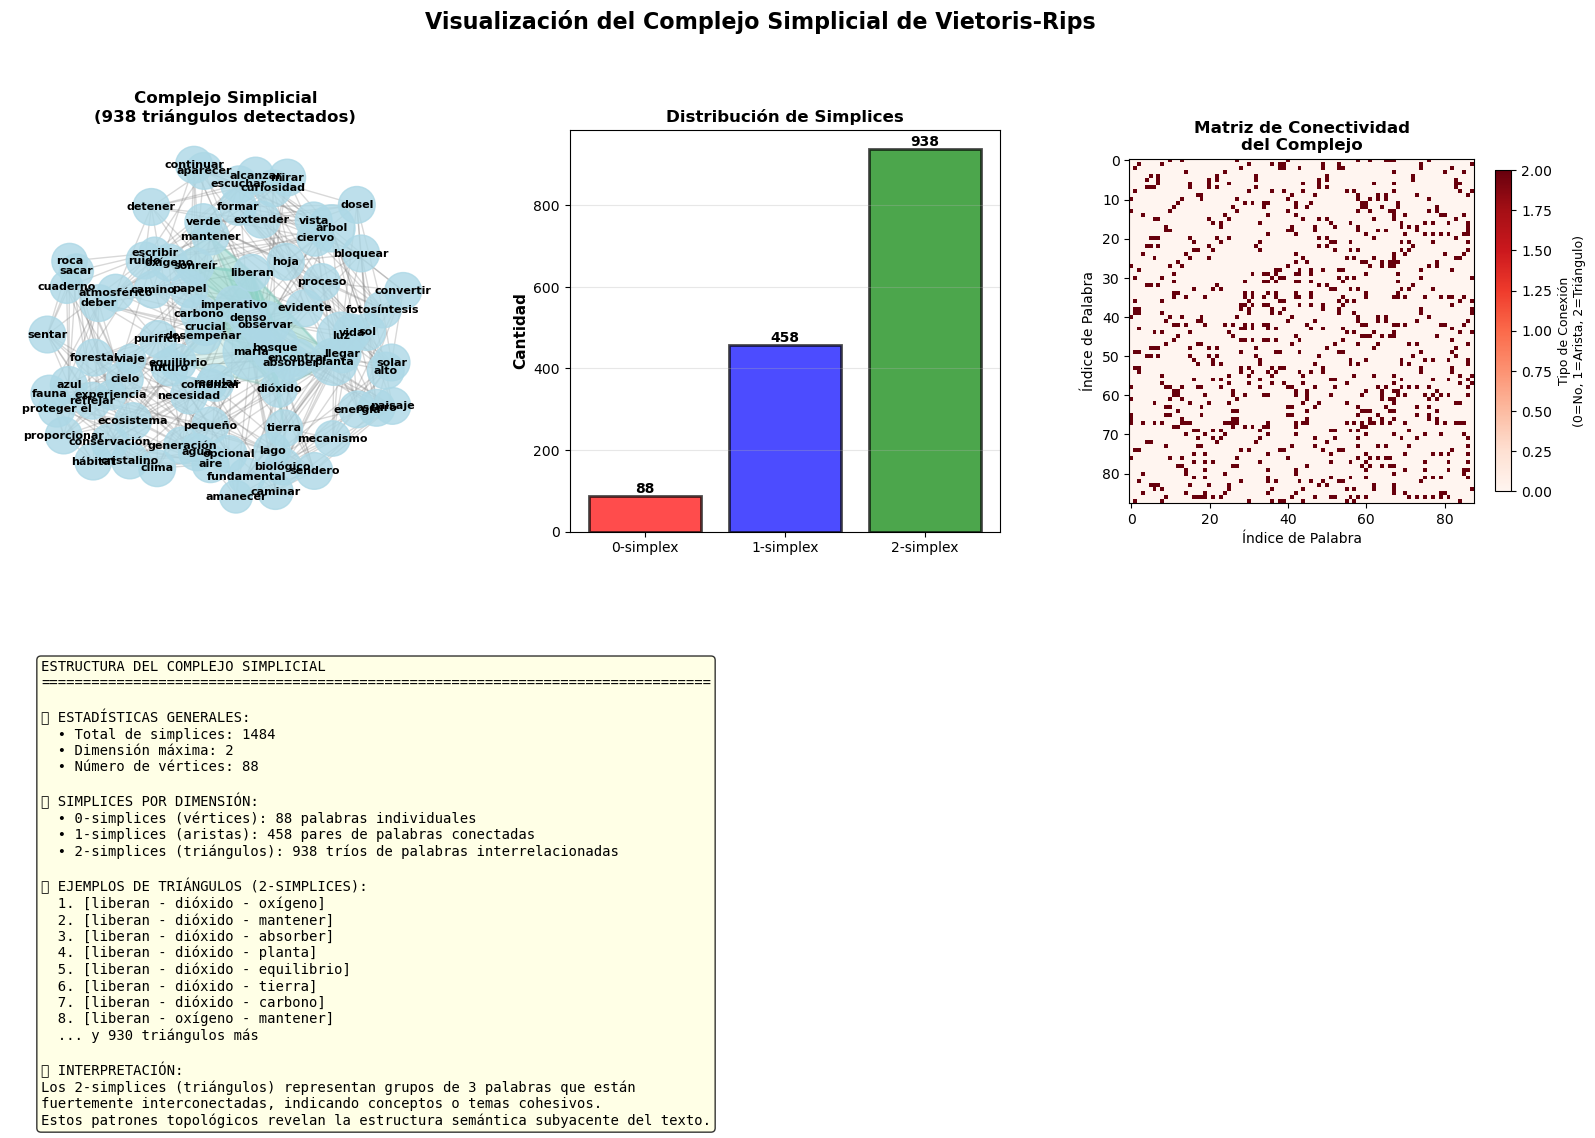


🎯 RESUMEN DE LA VISUALIZACIÓN:
  ✓ Complejo simplicial graficado exitosamente
  ✓ 938 triángulos (2-simplices) detectados
  ✓ Estructura topológica del texto revelada


In [17]:
# Visualización del Complejo Simplicial
def visualizar_complejo_simplicial(simplex_tree, G, vocab, max_simplices_mostrar=50):
    """Visualiza el complejo simplicial de múltiples formas"""
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Panel 1: Grafo base con triángulos marcados
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Layout del grafo
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    
    # Obtener 2-simplices (triángulos) del complejo
    triangulos = []
    for simplex in simplex_tree.get_skeleton(2):
        if len(simplex[0]) == 3:  # Es un triángulo
            triangulos.append(simplex[0])
    
    # Dibujar aristas del grafo
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, edge_color='gray', ax=ax1)
    
    # Marcar triángulos con colores
    colores_triangulos = plt.cm.Set3(np.linspace(0, 1, len(triangulos)))
    for i, triangulo in enumerate(triangulos[:10]):  # Mostrar solo primeros 10
        try:
            # Verificar que todos los vértices del triángulo estén en el grafo
            nodos_triangulo = [vocab[idx] for idx in triangulo if idx < len(vocab)]
            if len(nodos_triangulo) == 3 and all(nodo in G.nodes() for nodo in nodos_triangulo):
                # Dibujar el triángulo
                triangle_pos = [pos[nodo] for nodo in nodos_triangulo]
                triangle = plt.Polygon(triangle_pos, alpha=0.3, 
                                     color=colores_triangulos[i], 
                                     edgecolor='black', linewidth=2)
                ax1.add_patch(triangle)
        except (IndexError, KeyError):
            continue
    
    # Dibujar nodos
    node_sizes = [200 + 50 * G.degree(node) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.8, ax=ax1)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax1)
    
    ax1.set_title(f'Complejo Simplicial\n({len(triangulos)} triángulos detectados)', 
                  fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Panel 2: Distribución de simplices por dimensión
    ax2 = fig.add_subplot(gs[0, 1])
    
    dims = []
    counts = []
    for dim in range(simplex_tree.dimension() + 1):
        count = sum(1 for simplex in simplex_tree.get_skeleton(dim) 
                   if len(simplex[0]) == dim + 1)
        dims.append(f'{dim}-simplex')
        counts.append(count)
    
    bars = ax2.bar(dims, counts, color=['red', 'blue', 'green', 'purple'][:len(dims)], 
                   alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
    ax2.set_title('Distribución de Simplices', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores en las barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Panel 3: Matriz de adyacencia del complejo
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Crear matriz de adyacencia ampliada (incluyendo conexiones de orden superior)
    n_vocab = len(vocab)
    matriz_complejo = np.zeros((n_vocab, n_vocab))
    
    # Agregar conexiones de 1-simplices (aristas)
    for simplex in simplex_tree.get_skeleton(1):
        if len(simplex[0]) == 2:
            i, j = simplex[0]
            if i < n_vocab and j < n_vocab:
                matriz_complejo[i, j] = 1
                matriz_complejo[j, i] = 1
    
    # Agregar conexiones de 2-simplices (triángulos)
    for simplex in simplex_tree.get_skeleton(2):
        if len(simplex[0]) == 3:
            for i in range(3):
                for j in range(i+1, 3):
                    idx_i, idx_j = simplex[0][i], simplex[0][j]
                    if idx_i < n_vocab and idx_j < n_vocab:
                        matriz_complejo[idx_i, idx_j] = 2  # Valor 2 para triángulos
                        matriz_complejo[idx_j, idx_i] = 2
    
    im = ax3.imshow(matriz_complejo, cmap='Reds', interpolation='nearest')
    ax3.set_title('Matriz de Conectividad\ndel Complejo', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Índice de Palabra', fontsize=10)
    ax3.set_ylabel('Índice de Palabra', fontsize=10)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
    cbar.set_label('Tipo de Conexión\n(0=No, 1=Arista, 2=Triángulo)', fontsize=9)
    
    # Panel 4: Lista de simplices más importantes
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis('off')
    
    info_text = "ESTRUCTURA DEL COMPLEJO SIMPLICIAL\n" + "="*80 + "\n\n"
    
    # Información general
    info_text += f"📊 ESTADÍSTICAS GENERALES:\n"
    info_text += f"  • Total de simplices: {simplex_tree.num_simplices()}\n"
    info_text += f"  • Dimensión máxima: {simplex_tree.dimension()}\n"
    info_text += f"  • Número de vértices: {simplex_tree.num_vertices()}\n\n"
    
    # Simplices por dimensión
    info_text += f"📈 SIMPLICES POR DIMENSIÓN:\n"
    for dim in range(simplex_tree.dimension() + 1):
        count = sum(1 for simplex in simplex_tree.get_skeleton(dim) 
                   if len(simplex[0]) == dim + 1)
        if dim == 0:
            info_text += f"  • {dim}-simplices (vértices): {count} palabras individuales\n"
        elif dim == 1:
            info_text += f"  • {dim}-simplices (aristas): {count} pares de palabras conectadas\n"
        elif dim == 2:
            info_text += f"  • {dim}-simplices (triángulos): {count} tríos de palabras interrelacionadas\n"
        else:
            info_text += f"  • {dim}-simplices: {count} grupos de {dim+1} palabras\n"
    
    # Mostrar algunos triángulos importantes
    if triangulos:
        info_text += f"\n🔺 EJEMPLOS DE TRIÁNGULOS (2-SIMPLICES):\n"
        for i, triangulo in enumerate(triangulos[:8]):
            try:
                palabras_triangulo = [vocab[idx] for idx in triangulo if idx < len(vocab)]
                if len(palabras_triangulo) == 3:
                    info_text += f"  {i+1}. [{' - '.join(palabras_triangulo)}]\n"
            except IndexError:
                continue
        
        if len(triangulos) > 8:
            info_text += f"  ... y {len(triangulos)-8} triángulos más\n"
    
    info_text += f"\n💡 INTERPRETACIÓN:\n"
    info_text += f"Los 2-simplices (triángulos) representan grupos de 3 palabras que están\n"
    info_text += f"fuertemente interconectadas, indicando conceptos o temas cohesivos.\n"
    info_text += f"Estos patrones topológicos revelan la estructura semántica subyacente del texto."
    
    ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Visualización del Complejo Simplicial de Vietoris-Rips', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    return triangulos

# Ejecutar visualización
triangulos_detectados = visualizar_complejo_simplicial(simplex_tree, G, vocab)

print(f"\n🎯 RESUMEN DE LA VISUALIZACIÓN:")
print(f"  ✓ Complejo simplicial graficado exitosamente")
print(f"  ✓ {len(triangulos_detectados)} triángulos (2-simplices) detectados")
print(f"  ✓ Estructura topológica del texto revelada")

In [ ]:
# Visualización Simplificada: Complejo Simplicial sobre Grafo
def visualizar_complejo_sobre_grafo(simplex_tree, G, vocab):
    """Visualiza el complejo simplicial directamente superpuesto sobre el grafo"""
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Layout del grafo (mismo seed para consistencia)
    pos = nx.spring_layout(G, k=1.8, iterations=100, seed=42)
    
    # Obtener todos los triángulos (2-simplices)
    triangulos = []
    for simplex in simplex_tree.get_skeleton(2):
        if len(simplex[0]) == 3:
            triangulos.append(simplex[0])
    
    print(f"Dibujando {len(triangulos)} triángulos sobre el grafo...")
    
    # 1. DIBUJAR TRIÁNGULOS PRIMERO (como fondo)
    colores_triangulos = plt.cm.Set3(np.linspace(0, 1, len(triangulos)))
    triangulos_exitosos = []
    
    for i, triangulo in enumerate(triangulos):
        try:
            # Verificar que todos los vértices existan
            nodos_triangulo = [vocab[idx] for idx in triangulo if idx < len(vocab)]
            
            if len(nodos_triangulo) == 3 and all(nodo in pos for nodo in nodos_triangulo):
                # Obtener posiciones de los vértices del triángulo
                triangle_coords = np.array([pos[nodo] for nodo in nodos_triangulo])
                
                # Crear y dibujar el triángulo
                triangle = plt.Polygon(triangle_coords, 
                                     alpha=0.4,
                                     facecolor=colores_triangulos[i % len(colores_triangulos)],
                                     edgecolor='darkred',
                                     linewidth=2.5,
                                     linestyle='-')
                ax.add_patch(triangle)
                triangulos_exitosos.append(nodos_triangulo)
                
                # Agregar etiqueta del triángulo en el centro
                centro = triangle_coords.mean(axis=0)
                ax.annotate(f'T{i+1}', centro, 
                           fontsize=9, fontweight='bold', 
                           ha='center', va='center',
                           bbox=dict(boxstyle='round,pad=0.2', 
                                   facecolor='white', 
                                   edgecolor='darkred',
                                   alpha=0.8))
                
        except (IndexError, KeyError) as e:
            continue
    
    # 2. DIBUJAR ARISTAS DEL GRAFO
    # Aristas normales (más tenues)
    aristas_normales = []
    aristas_en_triangulos = set()
    
    # Identificar aristas que son parte de triángulos
    for triangulo_nodos in triangulos_exitosos:
        for i in range(3):
            for j in range(i+1, 3):
                if G.has_edge(triangulo_nodos[i], triangulo_nodos[j]):
                    aristas_en_triangulos.add((triangulo_nodos[i], triangulo_nodos[j]))
    
    # Separar aristas
    for u, v in G.edges():
        if (u, v) not in aristas_en_triangulos and (v, u) not in aristas_en_triangulos:
            aristas_normales.append((u, v))
    
    # Dibujar aristas normales
    nx.draw_networkx_edges(G, pos, 
                          edgelist=aristas_normales,
                          alpha=0.3, 
                          width=1, 
                          edge_color='gray', 
                          ax=ax)
    
    # Dibujar aristas que forman parte de triángulos (más destacadas)
    nx.draw_networkx_edges(G, pos, 
                          edgelist=list(aristas_en_triangulos),
                          alpha=0.8, 
                          width=3, 
                          edge_color='darkred', 
                          ax=ax)
    
    # 3. DIBUJAR NODOS
    # Tamaño proporcional al grado
    node_sizes = [300 + 150 * G.degree(node) for node in G.nodes()]
    
    # Color diferenciado para nodos que están en triángulos
    nodos_en_triangulos = set()
    for triangulo_nodos in triangulos_exitosos:
        nodos_en_triangulos.update(triangulo_nodos)
    
    node_colors = []
    for node in G.nodes():
        if node in nodos_en_triangulos:
            node_colors.append('orange')  # Nodos en triángulos
        else:
            node_colors.append('lightblue')  # Nodos solo en aristas
    
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)
    
    # 4. ETIQUETAS DE NODOS
    nx.draw_networkx_labels(G, pos, 
                           font_size=10, 
                           font_weight='bold',
                           font_color='black',
                           ax=ax)
    
    # 5. INFORMACIÓN Y LEYENDA
    ax.set_title(f'Complejo Simplicial de Vietoris-Rips sobre Grafo de Co-ocurrencia\n'
                f'{len(triangulos_exitosos)} Triángulos (2-simplices) • '
                f'{G.number_of_edges()} Aristas (1-simplices) • '
                f'{G.number_of_nodes()} Vértices (0-simplices)', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='orange', edgecolor='black', label='Nodos en triángulos'),
        Patch(facecolor='lightblue', edgecolor='black', label='Nodos solo en aristas'),
        plt.Line2D([0], [0], color='darkred', linewidth=3, label='Aristas en triángulos'),
        plt.Line2D([0], [0], color='gray', linewidth=1, alpha=0.3, label='Aristas simples'),
        Patch(facecolor='lightgreen', alpha=0.4, edgecolor='darkred', 
              linewidth=2, label='2-simplices (triángulos)')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', 
              bbox_to_anchor=(1.15, 1), fontsize=11)
    
    ax.axis('off')
    
    # Ajustar límites para mejor visualización
    ax.margins(0.1)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen de la visualización
    print(f"\n🎯 RESUMEN DE LA VISUALIZACIÓN:")
    print(f"  ✓ {len(triangulos_exitosos)} triángulos superpuestos exitosamente")
    print(f"  ✓ {len(nodos_en_triangulos)} nodos participan en triángulos")
    print(f"  ✓ {len(aristas_en_triangulos)} aristas forman parte de triángulos")
    print(f"  ✓ Estructura topológica claramente visible")
    
    # Mostrar algunos ejemplos de triángulos
    if triangulos_exitosos:
        print(f"\n🔺 EJEMPLOS DE TRIÁNGULOS DETECTADOS:")
        for i, triangulo_nodos in enumerate(triangulos_exitosos[:5]):
            print(f"  T{i+1}: [{' ↔ '.join(triangulo_nodos)}]")
        if len(triangulos_exitosos) > 5:
            print(f"  ... y {len(triangulos_exitosos)-5} triángulos más")
    
    return triangulos_exitosos, nodos_en_triangulos

# Ejecutar la visualización
triangulos_detectados, nodos_triangulos = visualizar_complejo_sobre_grafo(simplex_tree, G, vocab)

## 6. Filtración y Homología Persistente

La **filtración** construye una secuencia de complejos simpliciales crecientes.
La **homología persistente** identifica características topológicas que persisten a través de múltiples escalas:

- **H₀**: Componentes conexas (clusters de palabras)
- **H₁**: Ciclos (relaciones cíclicas entre conceptos)
- **H₂**: Cavidades (estructuras de orden superior)

In [11]:
# Calcular homología persistente con GUDHI
def calcular_persistencia_gudhi(simplex_tree):
    """Calcula homología persistente usando GUDHI"""
    # Calcular persistencia
    persistence = simplex_tree.persistence()
    
    # Organizar por dimensión
    persistence_por_dim = {}
    for dim, (birth, death) in persistence:
        if dim not in persistence_por_dim:
            persistence_por_dim[dim] = []
        persistence_por_dim[dim].append((birth, death))
    
    return persistence, persistence_por_dim

persistence, persistence_por_dim = calcular_persistencia_gudhi(simplex_tree)

print("Homología Persistente:")
print(f"  Total de características: {len(persistence)}")
print("\nCaracterísticas por dimensión:")
for dim in sorted(persistence_por_dim.keys()):
    print(f"  H{dim}: {len(persistence_por_dim[dim])} características")
    
    # Calcular persistencia (longevidad)
    persistencias = []
    for birth, death in persistence_por_dim[dim]:
        if death != float('inf'):
            persistencias.append(death - birth)
    
    if persistencias:
        print(f"     Persistencia promedio: {np.mean(persistencias):.4f}")
        print(f"     Persistencia máxima: {np.max(persistencias):.4f}")

Homología Persistente:
  Total de características: 92

Características por dimensión:
  H0: 88 características
     Persistencia promedio: 0.3052
     Persistencia máxima: 0.3959
  H1: 4 características
     Persistencia promedio: 0.1806
     Persistencia máxima: 0.2115


## 7. Diagramas de Persistencia y Códigos de Barras

Visualizamos la homología persistente de dos formas:

1. **Diagrama de Persistencia**: Puntos (nacimiento, muerte) de características
2. **Código de Barras**: Intervalos de existencia de cada característica

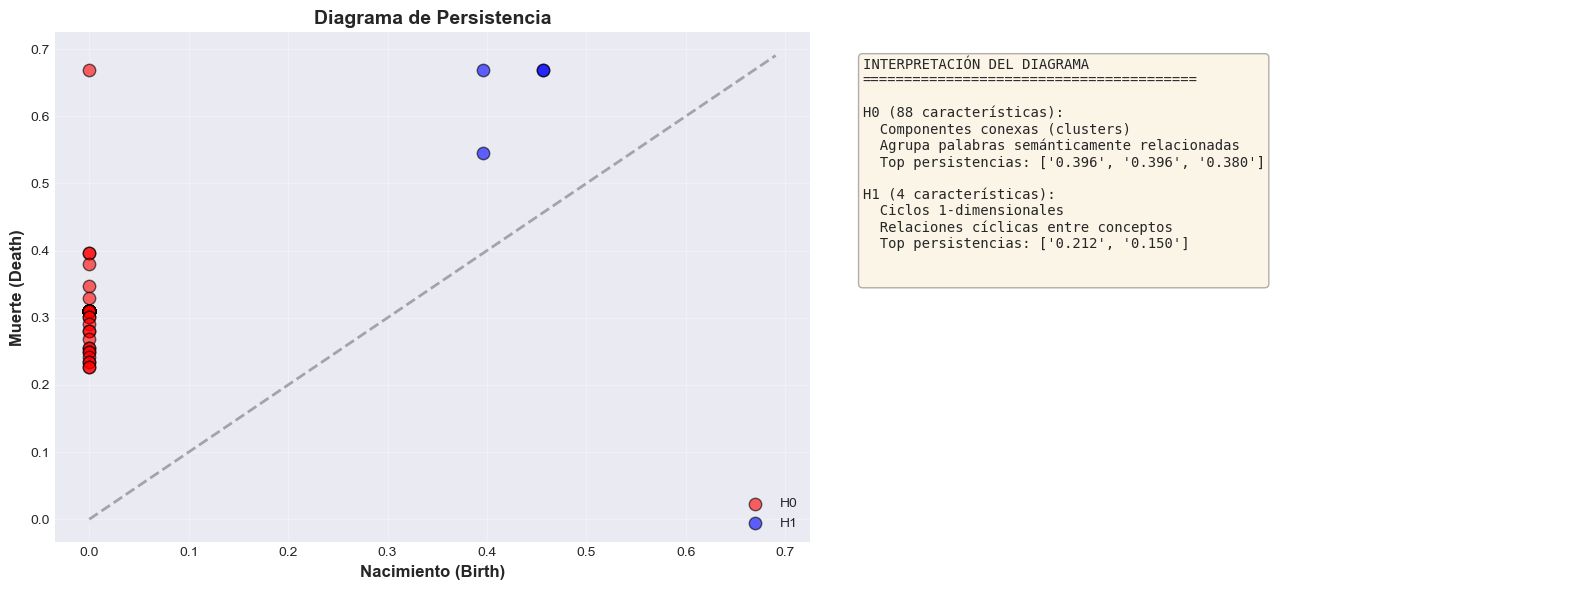

In [12]:
# Diagrama de persistencia
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Diagrama de persistencia
ax = axes[0]
colors = ['red', 'blue', 'green', 'purple']

for dim in sorted(persistence_por_dim.keys()):
    births = []
    deaths = []
    
    for birth, death in persistence_por_dim[dim]:
        births.append(birth)
        if death == float('inf'):
            deaths.append(matriz_distancias[matriz_distancias < np.inf].max())
        else:
            deaths.append(death)
    
    ax.scatter(births, deaths, c=colors[dim % len(colors)], 
               label=f'H{dim}', s=80, alpha=0.6, edgecolors='black', linewidth=1)

# Línea diagonal
lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=2)

ax.set_xlabel('Nacimiento (Birth)', fontsize=12, fontweight='bold')
ax.set_ylabel('Muerte (Death)', fontsize=12, fontweight='bold')
ax.set_title('Diagrama de Persistencia', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Información de persistencia
ax = axes[1]
ax.axis('off')

info_text = "INTERPRETACIÓN DEL DIAGRAMA\n" + "="*40 + "\n\n"

for dim in sorted(persistence_por_dim.keys()):
    info_text += f"H{dim} ({len(persistence_por_dim[dim])} características):\n"
    
    if dim == 0:
        info_text += "  Componentes conexas (clusters)\n"
        info_text += "  Agrupa palabras semánticamente relacionadas\n"
    elif dim == 1:
        info_text += "  Ciclos 1-dimensionales\n"
        info_text += "  Relaciones cíclicas entre conceptos\n"
    elif dim == 2:
        info_text += "  Cavidades 2-dimensionales\n"
        info_text += "  Estructuras semánticas complejas\n"
    
    # Top 3 características más persistentes
    pers_values = []
    for birth, death in persistence_por_dim[dim]:
        if death != float('inf'):
            pers_values.append(death - birth)
    
    if pers_values:
        top_pers = sorted(pers_values, reverse=True)[:3]
        info_text += f"  Top persistencias: {[f'{p:.3f}' for p in top_pers]}\n"
    
    info_text += "\n"

ax.text(0.05, 0.95, info_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', 
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

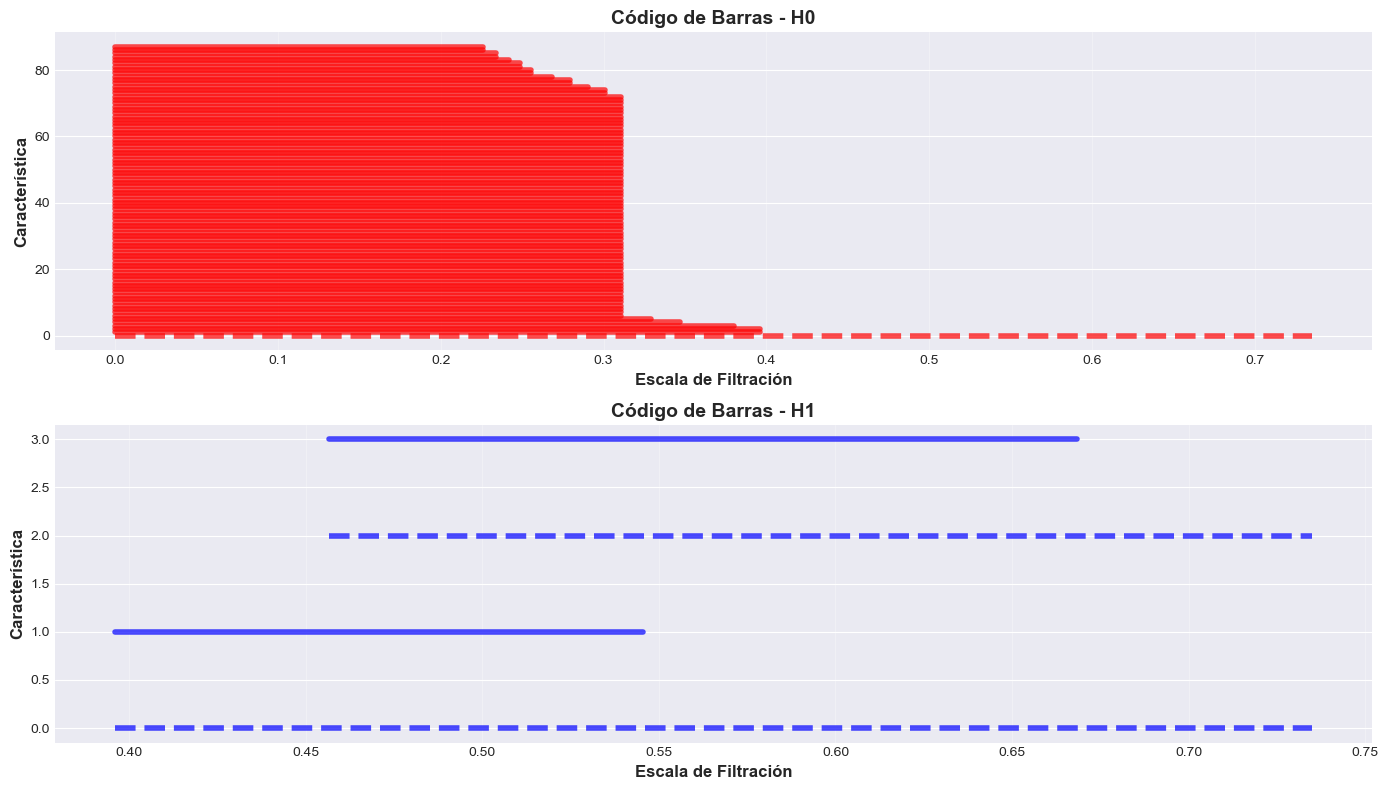

In [13]:
# Código de barras
fig, axes = plt.subplots(len(persistence_por_dim), 1, 
                         figsize=(14, 4 * len(persistence_por_dim)))

if len(persistence_por_dim) == 1:
    axes = [axes]

colors_bar = ['red', 'blue', 'green', 'purple']

for idx, dim in enumerate(sorted(persistence_por_dim.keys())):
    ax = axes[idx]
    
    # Ordenar por nacimiento
    intervals = sorted(persistence_por_dim[dim], key=lambda x: x[0])
    
    for i, (birth, death) in enumerate(intervals):
        if death == float('inf'):
            death = matriz_distancias[matriz_distancias < np.inf].max() * 1.1
            ax.plot([birth, death], [i, i], color=colors_bar[dim % len(colors_bar)], 
                   linewidth=4, alpha=0.7, linestyle='--')
        else:
            ax.plot([birth, death], [i, i], color=colors_bar[dim % len(colors_bar)], 
                   linewidth=4, alpha=0.7)
    
    ax.set_xlabel('Escala de Filtración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Característica', fontsize=12, fontweight='bold')
    ax.set_title(f'Código de Barras - H{dim}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 8. Análisis Alternativo con Ripser

Usamos Ripser como método complementario para validar resultados.

Resultados con Ripser:
  H0: 88 características
  H1: 4 características
  H2: 0 características


ValueError: zero-size array to reduction operation minimum which has no identity

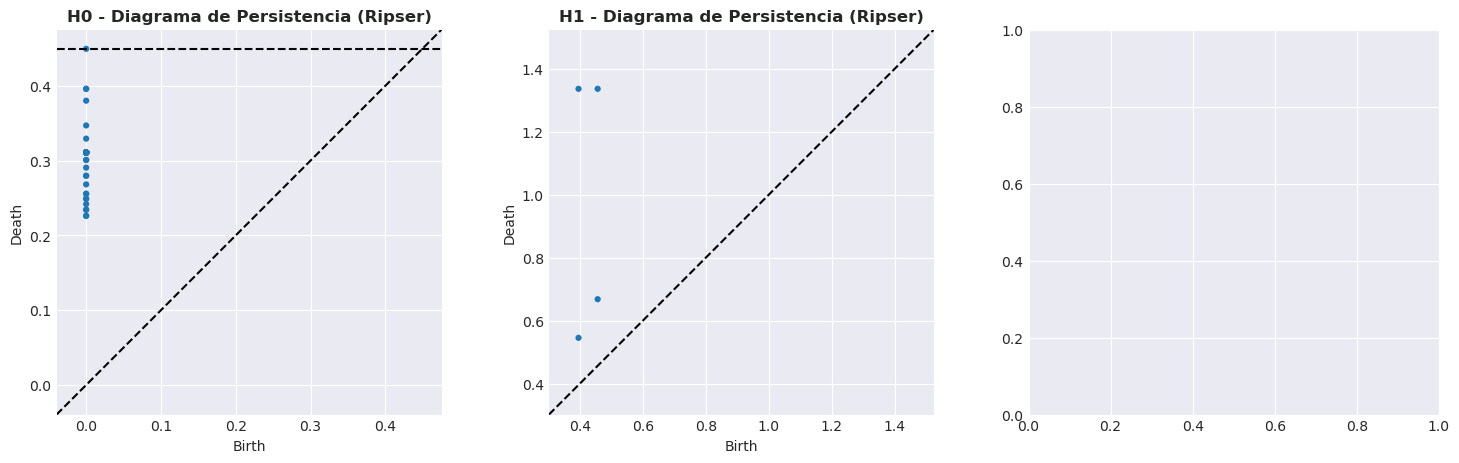

In [14]:
# Calcular persistencia con Ripser
matriz_finita = matriz_distancias.copy()
matriz_finita[np.isinf(matriz_finita)] = matriz_distancias[matriz_distancias < np.inf].max() * 2

diagrams_ripser = ripser(matriz_finita, maxdim=2, distance_matrix=True)['dgms']

print("Resultados con Ripser:")
for dim, dgm in enumerate(diagrams_ripser):
    print(f"  H{dim}: {len(dgm)} características")

# Visualización con persim
fig, axes = plt.subplots(1, len(diagrams_ripser), figsize=(6*len(diagrams_ripser), 5))

if len(diagrams_ripser) == 1:
    axes = [axes]

for dim, (ax, dgm) in enumerate(zip(axes, diagrams_ripser)):
    persim.plot_diagrams(dgm, ax=ax, legend=False)
    ax.set_title(f'H{dim} - Diagrama de Persistencia (Ripser)', 
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Análisis e Interpretación del Texto mediante ATD

Interpretamos los resultados topológicos para caracterizar el texto:

### Componentes Conexas (H₀)
- Clusters de palabras representan temas o dominios semánticos
- Múltiples componentes persistentes → texto con múltiples temas
- Componentes que nacen y mueren rápido → transiciones narrativas

### Ciclos (H₁)
- Ciclos cortos → relaciones bidireccionales (narrativa)
- Ciclos largos → conceptos interrelacionados (expositivo)
- Muchos ciclos → texto descriptivo con múltiples perspectivas

### Cavidades (H₂)
- Presencia de cavidades → estructura argumentativa compleja
- Ausencia de cavidades → estructura lineal simple

In [15]:
def analizar_tipo_texto(persistence_por_dim, texto_original):
    """Analiza el tipo de texto basándose en características topológicas"""
    
    analisis = {
        'narrativo': 0,
        'descriptivo': 0,
        'expositivo': 0,
        'argumentativo': 0
    }
    
    explicaciones = []
    
    # Análisis de H0 (componentes conexas)
    if 0 in persistence_por_dim:
        h0 = persistence_por_dim[0]
        num_componentes = len(h0)
        
        # Persistencias de componentes
        persistencias_h0 = []
        for birth, death in h0:
            if death != float('inf'):
                persistencias_h0.append(death - birth)
        
        if persistencias_h0:
            variabilidad = np.std(persistencias_h0)
            
            # Muchos componentes con alta variabilidad → narrativo
            if num_componentes > 5 and variabilidad > 0.05:
                analisis['narrativo'] += 2
                explicaciones.append(
                    f"✓ NARRATIVO: {num_componentes} clusters con variabilidad {variabilidad:.3f} "
                    "sugieren transiciones entre escenas/eventos"
                )
            
            # Pocos componentes muy persistentes → descriptivo
            if num_componentes <= 5 and max(persistencias_h0) > 0.2:
                analisis['descriptivo'] += 2
                explicaciones.append(
                    f"✓ DESCRIPTIVO: Pocos clusters ({num_componentes}) muy persistentes "
                    "indican enfoque en descripciones detalladas"
                )
    
    # Análisis de H1 (ciclos)
    if 1 in persistence_por_dim:
        h1 = persistence_por_dim[1]
        num_ciclos = len(h1)
        
        persistencias_h1 = []
        for birth, death in h1:
            if death != float('inf'):
                persistencias_h1.append(death - birth)
        
        if persistencias_h1:
            pers_promedio = np.mean(persistencias_h1)
            
            # Muchos ciclos cortos → narrativo (acciones que se entrelazan)
            if num_ciclos > 3 and pers_promedio < 0.15:
                analisis['narrativo'] += 1
                explicaciones.append(
                    f"✓ NARRATIVO: {num_ciclos} ciclos cortos (pers={pers_promedio:.3f}) "
                    "representan relaciones causales entre eventos"
                )
            
            # Ciclos persistentes → expositivo (conceptos interrelacionados)
            if num_ciclos > 0 and pers_promedio > 0.15:
                analisis['expositivo'] += 2
                explicaciones.append(
                    f"✓ EXPOSITIVO: Ciclos persistentes (pers={pers_promedio:.3f}) "
                    "muestran interconexión conceptual"
                )
            
            # Muchos ciclos en general → descriptivo
            if num_ciclos > 5:
                analisis['descriptivo'] += 1
                explicaciones.append(
                    f"✓ DESCRIPTIVO: {num_ciclos} ciclos indican múltiples relaciones "
                    "entre elementos descritos"
                )
    
    # Análisis de H2 (cavidades)
    if 2 in persistence_por_dim:
        h2 = persistence_por_dim[2]
        num_cavidades = len(h2)
        
        if num_cavidades > 0:
            analisis['argumentativo'] += 2
            analisis['expositivo'] += 1
            explicaciones.append(
                f"✓ ARGUMENTATIVO: {num_cavidades} cavidades 2D revelan estructura "
                "argumentativa compleja o razonamiento elaborado"
            )
        else:
            explicaciones.append(
                "○ Sin cavidades 2D: estructura relativamente simple o lineal"
            )
    
    # Análisis textual complementario
    oraciones = texto_original.split('.')
    palabras_narrativas = ['comenzó', 'caminaba', 'escuchó', 'apareció', 'continuó', 
                          'encontró', 'llegó', 'sacó']
    palabras_descriptivas = ['era', 'denso', 'oscuro', 'altos', 'verde', 'cristalina', 
                            'azul', 'pequeño']
    palabras_expositivas = ['es', 'proceso', 'mediante', 'fundamental', 'mecanismo']
    palabras_argumentativas = ['evidente', 'debemos', 'porque', 'necesidad', 'imperativa']
    
    texto_lower = texto_original.lower()
    
    count_narrativas = sum(1 for p in palabras_narrativas if p in texto_lower)
    count_descriptivas = sum(1 for p in palabras_descriptivas if p in texto_lower)
    count_expositivas = sum(1 for p in palabras_expositivas if p in texto_lower)
    count_argumentativas = sum(1 for p in palabras_argumentativas if p in texto_lower)
    
    analisis['narrativo'] += count_narrativas * 0.5
    analisis['descriptivo'] += count_descriptivas * 0.5
    analisis['expositivo'] += count_expositivas * 0.5
    analisis['argumentativo'] += count_argumentativas * 0.5
    
    return analisis, explicaciones

analisis, explicaciones = analizar_tipo_texto(persistence_por_dim, texto_ejemplo)

print("="*70)
print("ANÁLISIS DEL TIPO DE TEXTO MEDIANTE ATD")
print("="*70)

print("\n📊 EVIDENCIAS TOPOLÓGICAS:\n")
for exp in explicaciones:
    print(f"  {exp}\n")

print("\n" + "="*70)
print("📈 PUNTUACIONES POR TIPO DE TEXTO:")
print("="*70)

# Normalizar puntuaciones
total = sum(analisis.values())
if total > 0:
    for tipo in sorted(analisis.keys(), key=lambda x: analisis[x], reverse=True):
        porcentaje = (analisis[tipo] / total) * 100
        barra = '█' * int(porcentaje / 2)
        print(f"  {tipo.upper():15s}: {porcentaje:5.1f}% {barra}")

print("\n" + "="*70)
print("🎯 CONCLUSIÓN:")
print("="*70)

tipo_dominante = max(analisis, key=analisis.get)
segundo_tipo = sorted(analisis, key=analisis.get, reverse=True)[1]

print(f"\nEl texto es principalmente {tipo_dominante.upper()} con elementos")
print(f"{segundo_tipo.upper()}S.")
print(f"\nEsto se evidencia en la estructura topológica que revela:")
if tipo_dominante == 'narrativo':
    print("  - Múltiples transiciones temporales y cambios de escena")
    print("  - Relaciones causales entre eventos")
    print("  - Progresión temporal marcada")
elif tipo_dominante == 'descriptivo':
    print("  - Clusters densos de vocabulario descriptivo")
    print("  - Múltiples relaciones entre características de entidades")
    print("  - Enfoque en detalles y cualidades")
elif tipo_dominante == 'expositivo':
    print("  - Conceptos fuertemente interconectados")
    print("  - Estructura explicativa clara")
    print("  - Relaciones conceptuales complejas")
elif tipo_dominante == 'argumentativo':
    print("  - Estructura argumentativa de alto nivel")
    print("  - Razonamiento elaborado")
    print("  - Conexiones lógicas complejas")

print("\n" + "="*70)

ANÁLISIS DEL TIPO DE TEXTO MEDIANTE ATD

📊 EVIDENCIAS TOPOLÓGICAS:

  ✓ EXPOSITIVO: Ciclos persistentes (pers=0.181) muestran interconexión conceptual


📈 PUNTUACIONES POR TIPO DE TEXTO:
  EXPOSITIVO     :  31.0% ███████████████
  DESCRIPTIVO    :  27.6% █████████████
  NARRATIVO      :  24.1% ████████████
  ARGUMENTATIVO  :  17.2% ████████

🎯 CONCLUSIÓN:

El texto es principalmente EXPOSITIVO con elementos
DESCRIPTIVOS.

Esto se evidencia en la estructura topológica que revela:
  - Conceptos fuertemente interconectados
  - Estructura explicativa clara
  - Relaciones conceptuales complejas



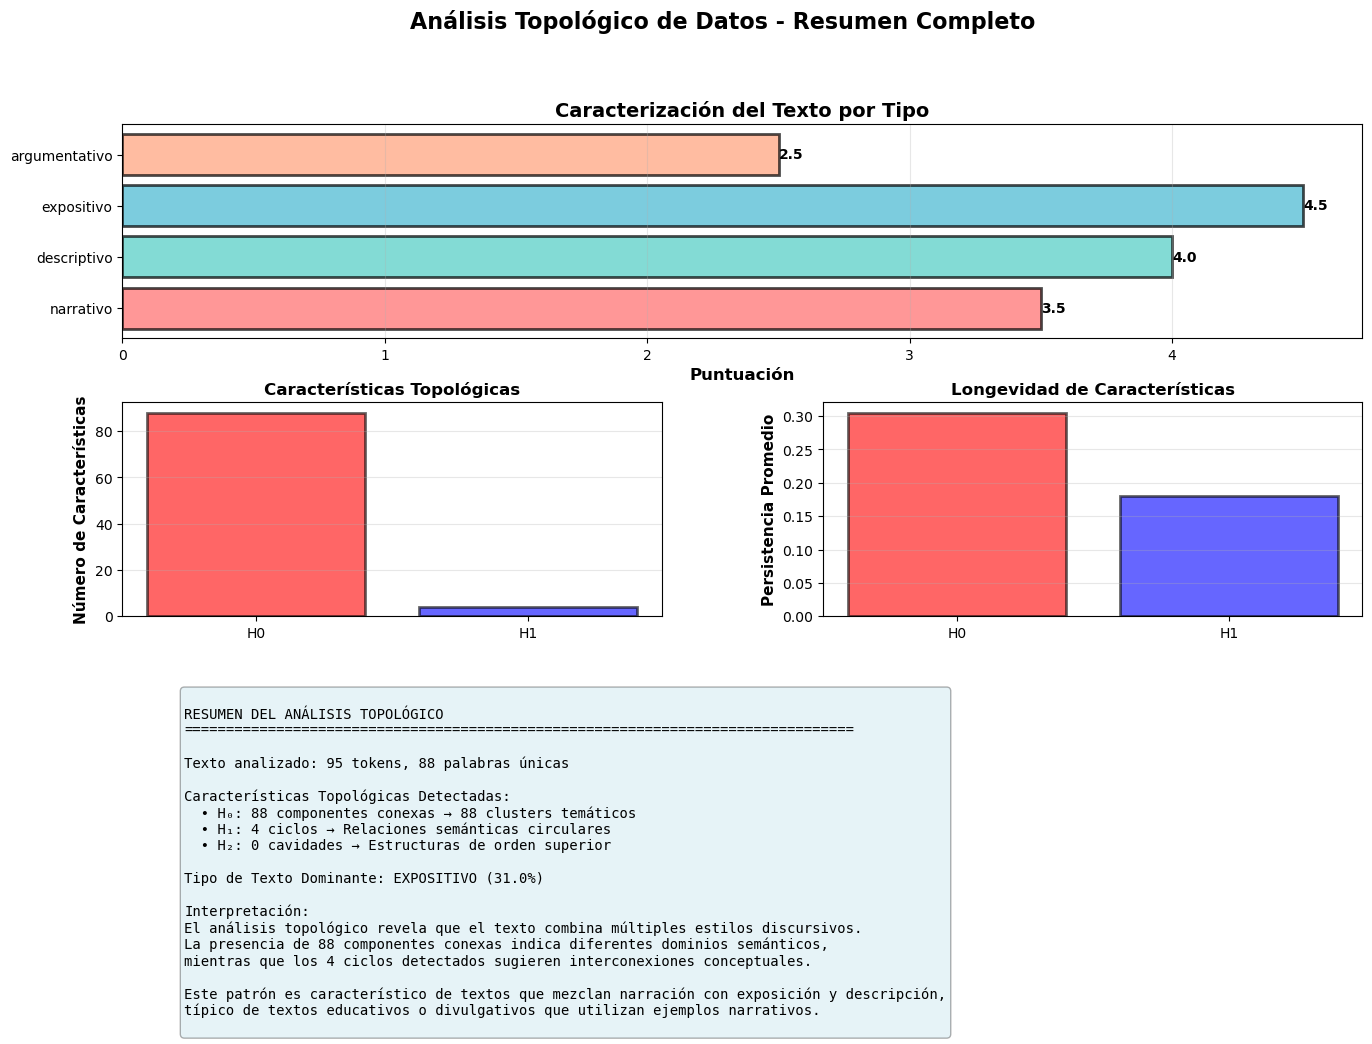

In [16]:
# Visualización final: resumen del análisis
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Panel 1: Distribución de tipos de texto
ax1 = fig.add_subplot(gs[0, :])
tipos = list(analisis.keys())
valores = [analisis[t] for t in tipos]
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = ax1.barh(tipos, valores, color=colores, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xlabel('Puntuación', fontsize=12, fontweight='bold')
ax1.set_title('Caracterización del Texto por Tipo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for bar, val in zip(bars, valores):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}', ha='left', va='center', fontweight='bold', fontsize=10)

# Panel 2: Características topológicas por dimensión
ax2 = fig.add_subplot(gs[1, 0])
dims = sorted(persistence_por_dim.keys())
counts = [len(persistence_por_dim[d]) for d in dims]

ax2.bar([f'H{d}' for d in dims], counts, color=['red', 'blue', 'green'][:len(dims)], 
        alpha=0.6, edgecolor='black', linewidth=2)
ax2.set_ylabel('Número de Características', fontsize=11, fontweight='bold')
ax2.set_title('Características Topológicas', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Persistencia promedio por dimensión
ax3 = fig.add_subplot(gs[1, 1])
pers_promedios = []

for dim in dims:
    pers = []
    for birth, death in persistence_por_dim[dim]:
        if death != float('inf'):
            pers.append(death - birth)
    if pers:
        pers_promedios.append(np.mean(pers))
    else:
        pers_promedios.append(0)

ax3.bar([f'H{d}' for d in dims], pers_promedios, 
        color=['red', 'blue', 'green'][:len(dims)], 
        alpha=0.6, edgecolor='black', linewidth=2)
ax3.set_ylabel('Persistencia Promedio', fontsize=11, fontweight='bold')
ax3.set_title('Longevidad de Características', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Panel 4: Resumen textual
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

resumen = f"""
RESUMEN DEL ANÁLISIS TOPOLÓGICO
{'='*80}

Texto analizado: {len(tokens)} tokens, {len(set(tokens))} palabras únicas

Características Topológicas Detectadas:
  • H₀: {len(persistence_por_dim.get(0, []))} componentes conexas → {len(persistence_por_dim.get(0, []))} clusters temáticos
  • H₁: {len(persistence_por_dim.get(1, []))} ciclos → Relaciones semánticas circulares
  • H₂: {len(persistence_por_dim.get(2, []))} cavidades → Estructuras de orden superior

Tipo de Texto Dominante: {tipo_dominante.upper()} ({(analisis[tipo_dominante]/sum(analisis.values()))*100:.1f}%)

Interpretación:
El análisis topológico revela que el texto combina múltiples estilos discursivos.
La presencia de {len(persistence_por_dim.get(0, []))} componentes conexas indica diferentes dominios semánticos,
mientras que los {len(persistence_por_dim.get(1, []))} ciclos detectados sugieren interconexiones conceptuales.

Este patrón es característico de textos que mezclan narración con exposición y descripción,
típico de textos educativos o divulgativos que utilizan ejemplos narrativos.
"""

ax4.text(0.05, 0.95, resumen, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Análisis Topológico de Datos - Resumen Completo', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 10. Conclusiones

Este pipeline de ATD ha permitido:

1. **Construir una representación topológica** del texto mediante grafos de co-ocurrencia y complejos simpliciales

2. **Identificar características persistentes** que revelan la estructura semántica subyacente

3. **Caracterizar el tipo de texto** basándose en patrones topológicos:
   - Componentes conexas revelan organización temática
   - Ciclos indican relaciones conceptuales complejas
   - Cavidades sugieren estructuras argumentativas elaboradas

4. **Descubrir contenido mixto** donde el texto combina elementos narrativos, descriptivos, expositivos y argumentativos

### Ventajas del ATD para análisis de texto:
- Captura relaciones de orden superior (más allá de pares)
- Robusto ante ruido y variaciones
- Revela estructura global y local simultáneamente
- Independiente de la longitud del texto

### Aplicaciones futuras:
- Clasificación automática de géneros textuales
- Detección de cambios de estilo en textos largos
- Análisis comparativo de autores
- Identificación de plagios estructurales